In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')

In [2]:
from project_helper import *

## Models Without MSA Encoding

### Import, Split, and Standardize Data

In [3]:
df = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 13 columns):
year                                                                           928 non-null int64
MSA_orig                                                                       928 non-null object
MSA                                                                            928 non-null object
MSA_abbr                                                                       928 non-null object
now_married_except_separated                                                   928 non-null float64
less_than_high_school_diploma                                                  928 non-null float64
unmarried_portion_of_women_15_to_50_years_who_had_a_birth_in_past_12_months    928 non-null float64
households_with_food_stamp_snap_benefits                                       928 non-null float64
percentage_married_couple_family                                               928 non-null float64


In [5]:
# drop MSA names
df = df.drop(['MSA','MSA_orig','MSA_abbr'], axis=1)

In [6]:
# separate labels and features

label_col = 'murder_per_100_k'

x = df.drop([label_col], axis=1)
y = df[label_col]

print('Sizes match: {}'.format(len(x)==len(y)))

Sizes match: True


In [7]:
# train test split

from sklearn.model_selection import train_test_split

x_train_s, x_test_s, y_train, y_test = train_test_split(x,y, test_size=0.3)

print('Len x_train: {}'.format(len(x_train_s)))
print('Len x_test: {}'.format(len(x_test_s)))
print('Len y_train: {}'.format(len(y_train)))
print('Len x_test: {}'.format(len(y_test)))

Len x_train: 649
Len x_test: 279
Len y_train: 649
Len x_test: 279


In [8]:
# standardize data

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler().fit(x_train_s)

x_train = standardizer.transform(x_train_s)
x_test = standardizer.transform(x_test_s)

### Simple Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [10]:
# instantiate and fit models
def linear_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=15).fit(x_train, y_train)
    md['lasso'] = LassoCV(cv=15).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7]}).fit(x_train, y_train).best_estimator_
    
    return md

In [11]:
coeff_names = df.drop('murder_per_100_k',axis=1).columns

exp = run_experiment(linear_models, 10, x_train, y_train, x_test, y_test, coeff_names)

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### MSA-encoded Models Data Prep

In [12]:
df_2 = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [13]:
# OHE MSA names
df_2_dummies = pd.get_dummies(df_2['MSA_abbr'])

In [14]:
# drop MSA names
df_2 = df_2.drop(['MSA','MSA_orig','MSA_abbr'], axis=1)

In [15]:
# combine dataframes, preserving list of columns that need normalization
cols_to_norm = df_2.columns[:-1]
df_2 = pd.concat([df_2, df_2_dummies], axis=1)

In [16]:
# separate labels and features

label_col = 'murder_per_100_k'

x_2 = df_2.drop([label_col], axis=1)
y_2 = df_2[label_col]

print('Sizes match: {}'.format(len(x)==len(y)))

Sizes match: True


In [17]:
# train test split

from sklearn.model_selection import train_test_split

x_train_s_2, x_test_s_2, y_train_2, y_test_2 = train_test_split(x_2,y_2, test_size=0.3)

print('Len x_train: {}'.format(len(x_train_s)))
print('Len x_test: {}'.format(len(x_test_s)))
print('Len y_train: {}'.format(len(y_train)))
print('Len x_test: {}'.format(len(y_test)))

Len x_train: 649
Len x_test: 279
Len y_train: 649
Len x_test: 279


In [18]:
# standardize data
means = np.mean(x_train_s_2, axis=0)
stds = np.std(x_train_s_2, axis=0)

# initialize training containers
x_train_2 = x_train_s_2
x_test_2 = x_test_s_2

# standardize relevant data, will throw a warning
for i,c in enumerate(cols_to_norm):
    x_train_2[c] = (x_train_s_2[c]-means[i])/stds[i]
    x_test_2[c] = (x_test_s_2[c]-means[i])/stds[i]

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Running MSA-Encoded Models

In [19]:
coeff_2_names = df_2.drop('murder_per_100_k',axis=1).columns

exp_2 = run_experiment(linear_models, 10, x_train_2, y_train_2, x_test_2, y_test_2, coeff_2_names)

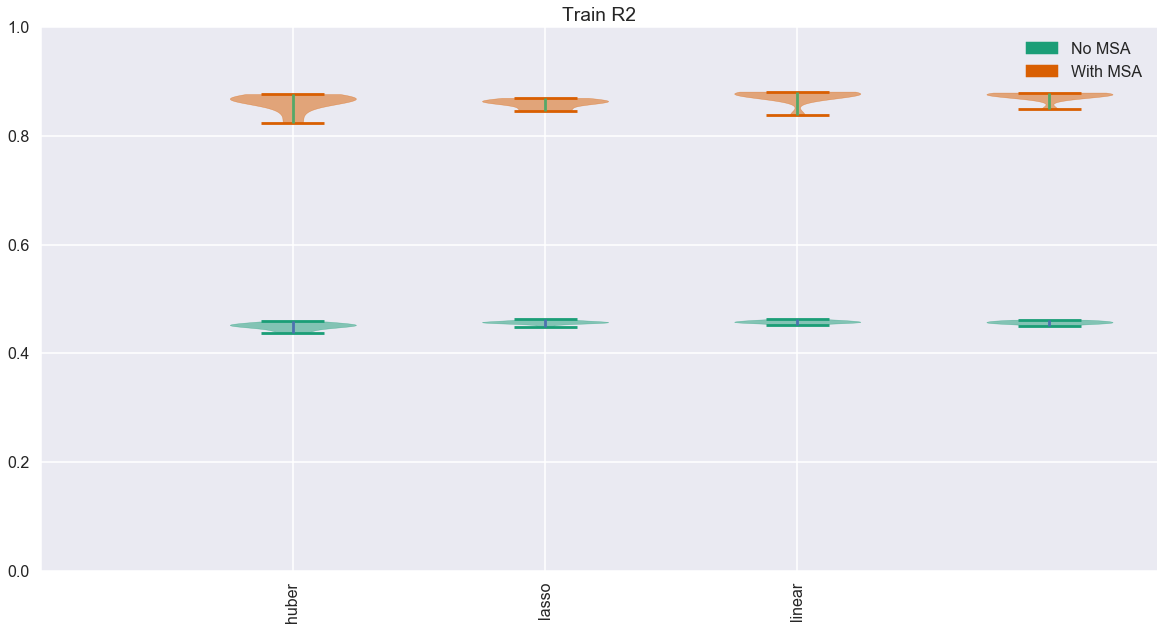

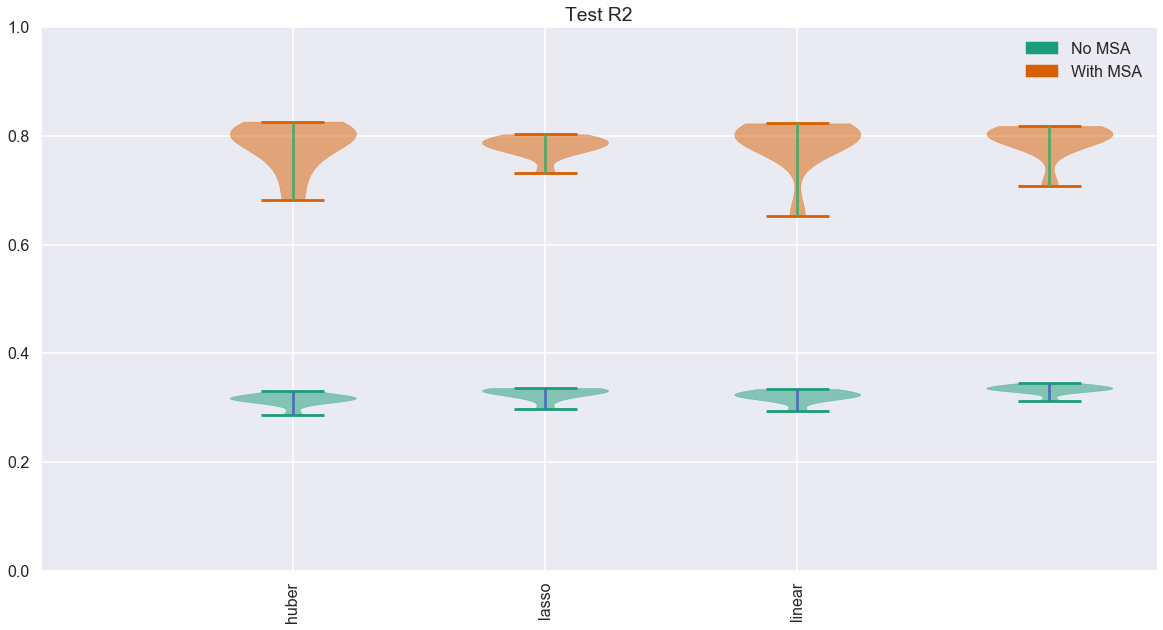

In [20]:
violin_coefs([exp, exp_2], ['Train R2','Test R2'], experiment_name=['No MSA','With MSA'], center_zero=False)

In [21]:
violin_coefs([exp, exp_2], coeff_names, experiment_name=['No MSA','With MSA'])